In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from lifelines import CoxPHFitter

sys.path.append(os.path.abspath('..'))
from utils.utils_constants import ARTERY_TYPES, DISEASE_TYPES, VESSEL_NEPTUNE_PAT_INFO_W_SCORE_W_FEATURE_PATH

SEVERITY_MAPPING = {
    '0:absent': 0,
    '1:mild (1-25%)': 1,
    '2:moderate (26-50%)': 2,
    '3:severe (>50%)': 3
}

CLININCAL_FEATURES = ['PAT_Sex', 'PAT_Hispanic', 'PAT_Cohort', 'PAT_Race', 'PAT_AgeV3', 'eGFRatBx', 'UPCRatBx', 
                      'Immunosupression_30dBfOrAtBx', 'ArterioSclerosis', 'ArterialHyalinosis']

VESSEL_NEPTUNE_PAT_INFO_W_SCORE_W_FEATURE_PATH = '/DataMount/NEPTUNE/Clinical_Data/Barisoni_NEPTUNE_clinical_20230620_Vessel_20240710_W_SCORE_W_FEATURE_measurements_exclude_hya_manual_lumen_convex.csv'

In [2]:
def binary_map(x, positive_value):
    return 1 if x == positive_value else 0

In [3]:
pat_df = pd.read_csv(VESSEL_NEPTUNE_PAT_INFO_W_SCORE_W_FEATURE_PATH)

# Applying the function to various columns
pat_df['PAT_Hispanic'] = pat_df['PAT_Hispanic'].apply(lambda x: binary_map(x, '1: Hispanic or Latino'))
pat_df['Immunosupression_30dBfOrAtBx'] = pat_df['Immunosupression_30dBfOrAtBx'].apply(lambda x: binary_map(x, '1: Yes'))
pat_df['PAT_Race'] = pat_df['PAT_Race'].apply(lambda x: binary_map(x, '3: Black/African American'))
pat_df['PAT_Sex'] = pat_df['PAT_Sex'].apply(lambda x: binary_map(x, '2: Female'))
pat_df['PAT_Cohort'] = pat_df['PAT_Cohort'].apply(lambda x: binary_map(x, '2 - MCD'))
pat_df['ArterioSclerosis'] = pat_df['ArterioSclerosis'].map(SEVERITY_MAPPING)
pat_df['ArterialHyalinosis'] = pat_df['ArterialHyalinosis'].map(SEVERITY_MAPPING)

covariates_to_normalize = ['PAT_AgeV3', 'eGFRatBx', 'UPCRatBx', 'ArterioSclerosis', 'ArterialHyalinosis']  # add numerical columns here
scaler = StandardScaler() # choose a scaler?
pat_df[covariates_to_normalize] = scaler.fit_transform(pat_df[covariates_to_normalize]) # in place

In [4]:
pat_df.shape

(247, 402)

In [5]:
# SCORE_FEATURES = ['Max_Arteriosclerosis_Severity_in_Arterioles', 'Median_Hyalinosis_Severity_in_Arterioles', 
#                   '75th_Arteriosclerosis_Severity_in_Interlobular_Arteries']
score_features = []  # Initialize an empty list to store feature names

for artery_type in ARTERY_TYPES:
    for disease_type in DISEASE_TYPES:
        for agg_metric in ["Max", "Median", "75th", "Mean", "NonZeroPct"]:
            score_feature_name = '_'.join([agg_metric, disease_type, "Severity", "in", artery_type])
            score_features.append(score_feature_name.replace(" ", "_"))
score_features

['Max_Arteriosclerosis_Severity_in_Arterioles',
 'Median_Arteriosclerosis_Severity_in_Arterioles',
 '75th_Arteriosclerosis_Severity_in_Arterioles',
 'Mean_Arteriosclerosis_Severity_in_Arterioles',
 'NonZeroPct_Arteriosclerosis_Severity_in_Arterioles',
 'Max_Hyalinosis_Severity_in_Arterioles',
 'Median_Hyalinosis_Severity_in_Arterioles',
 '75th_Hyalinosis_Severity_in_Arterioles',
 'Mean_Hyalinosis_Severity_in_Arterioles',
 'NonZeroPct_Hyalinosis_Severity_in_Arterioles',
 'Max_Arteriosclerosis_Severity_in_Interlobular_Arteries',
 'Median_Arteriosclerosis_Severity_in_Interlobular_Arteries',
 '75th_Arteriosclerosis_Severity_in_Interlobular_Arteries',
 'Mean_Arteriosclerosis_Severity_in_Interlobular_Arteries',
 'NonZeroPct_Arteriosclerosis_Severity_in_Interlobular_Arteries',
 'Max_Hyalinosis_Severity_in_Interlobular_Arteries',
 'Median_Hyalinosis_Severity_in_Interlobular_Arteries',
 '75th_Hyalinosis_Severity_in_Interlobular_Arteries',
 'Mean_Hyalinosis_Severity_in_Interlobular_Arteries',
 '

In [6]:
measurement_features = []
feature_names = [
        'Lumen Area',
        'Intima Area',
 'Media Area',
 'Hyalinosis Area',
 'Intima Average',
 'Intima Median',
#  'Intima Variance',
 'Intima Peak Height',
#  'Intima Peak Prominence',
 'Media Average',
 'Media Median',
#  'Media Variance',
 'Media Peak Height',
#  'Media Peak Prominence',
#  'Ratio Average',
#  'Ratio Median',
#  'Ratio Variance',
#  'Ratio Peak Height',
#  'Ratio Peak Prominence'
 ]

for feature_name in feature_names:
        for artery_type in ARTERY_TYPES:
                for agg_metric in ["Max", "Median", "75th", "Mean", "25th"]:
                        measurement_feature_name = '_'.join([agg_metric, feature_name, "in", artery_type])
                        measurement_features.append(measurement_feature_name.replace(" ", "_"))
measurement_features

['Max_Lumen_Area_in_Arterioles',
 'Median_Lumen_Area_in_Arterioles',
 '75th_Lumen_Area_in_Arterioles',
 'Mean_Lumen_Area_in_Arterioles',
 '25th_Lumen_Area_in_Arterioles',
 'Max_Lumen_Area_in_Interlobular_Arteries',
 'Median_Lumen_Area_in_Interlobular_Arteries',
 '75th_Lumen_Area_in_Interlobular_Arteries',
 'Mean_Lumen_Area_in_Interlobular_Arteries',
 '25th_Lumen_Area_in_Interlobular_Arteries',
 'Max_Lumen_Area_in_Arcuate_Arteries',
 'Median_Lumen_Area_in_Arcuate_Arteries',
 '75th_Lumen_Area_in_Arcuate_Arteries',
 'Mean_Lumen_Area_in_Arcuate_Arteries',
 '25th_Lumen_Area_in_Arcuate_Arteries',
 'Max_Intima_Area_in_Arterioles',
 'Median_Intima_Area_in_Arterioles',
 '75th_Intima_Area_in_Arterioles',
 'Mean_Intima_Area_in_Arterioles',
 '25th_Intima_Area_in_Arterioles',
 'Max_Intima_Area_in_Interlobular_Arteries',
 'Median_Intima_Area_in_Interlobular_Arteries',
 '75th_Intima_Area_in_Interlobular_Arteries',
 'Mean_Intima_Area_in_Interlobular_Arteries',
 '25th_Intima_Area_in_Interlobular_Arteri

In [7]:
for x in CLININCAL_FEATURES+measurement_features:
    if x not in pat_df.columns:
        print(x)

In [8]:
measurement_features

['Max_Lumen_Area_in_Arterioles',
 'Median_Lumen_Area_in_Arterioles',
 '75th_Lumen_Area_in_Arterioles',
 'Mean_Lumen_Area_in_Arterioles',
 '25th_Lumen_Area_in_Arterioles',
 'Max_Lumen_Area_in_Interlobular_Arteries',
 'Median_Lumen_Area_in_Interlobular_Arteries',
 '75th_Lumen_Area_in_Interlobular_Arteries',
 'Mean_Lumen_Area_in_Interlobular_Arteries',
 '25th_Lumen_Area_in_Interlobular_Arteries',
 'Max_Lumen_Area_in_Arcuate_Arteries',
 'Median_Lumen_Area_in_Arcuate_Arteries',
 '75th_Lumen_Area_in_Arcuate_Arteries',
 'Mean_Lumen_Area_in_Arcuate_Arteries',
 '25th_Lumen_Area_in_Arcuate_Arteries',
 'Max_Intima_Area_in_Arterioles',
 'Median_Intima_Area_in_Arterioles',
 '75th_Intima_Area_in_Arterioles',
 'Mean_Intima_Area_in_Arterioles',
 '25th_Intima_Area_in_Arterioles',
 'Max_Intima_Area_in_Interlobular_Arteries',
 'Median_Intima_Area_in_Interlobular_Arteries',
 '75th_Intima_Area_in_Interlobular_Arteries',
 'Mean_Intima_Area_in_Interlobular_Arteries',
 '25th_Intima_Area_in_Interlobular_Arteri

In [9]:
pat_df.dropna(subset = CLININCAL_FEATURES+score_features + measurement_features, inplace = True)
pat_df['DaysBXtoESRDorEGFR40_LR'] = pd.to_numeric(pat_df['DaysBXtoESRDorEGFR40_LR'], errors='coerce')
pat_df['ESRDorEGFR40BX_LR'] = pat_df['ESRDorEGFR40BX_LR'].map({'1: Yes': 1, '0: No': 0}).astype(int)
pat_df.shape

(198, 402)

In [10]:
CLININCAL_FEATURES_W_VISUAL = ['PAT_Sex',
 'PAT_Hispanic',
 'PAT_Cohort',
 'PAT_Race',
 'PAT_AgeV3',
 'eGFRatBx',
 'UPCRatBx',
 'Immunosupression_30dBfOrAtBx',
 'ArterioSclerosis',
 'ArterialHyalinosis']

CLININCAL_FEATURES = ['PAT_Sex',
 'PAT_Hispanic',
 'PAT_Cohort',
 'PAT_Race',
 'PAT_AgeV3',
 'eGFRatBx',
 'UPCRatBx',
 'Immunosupression_30dBfOrAtBx']

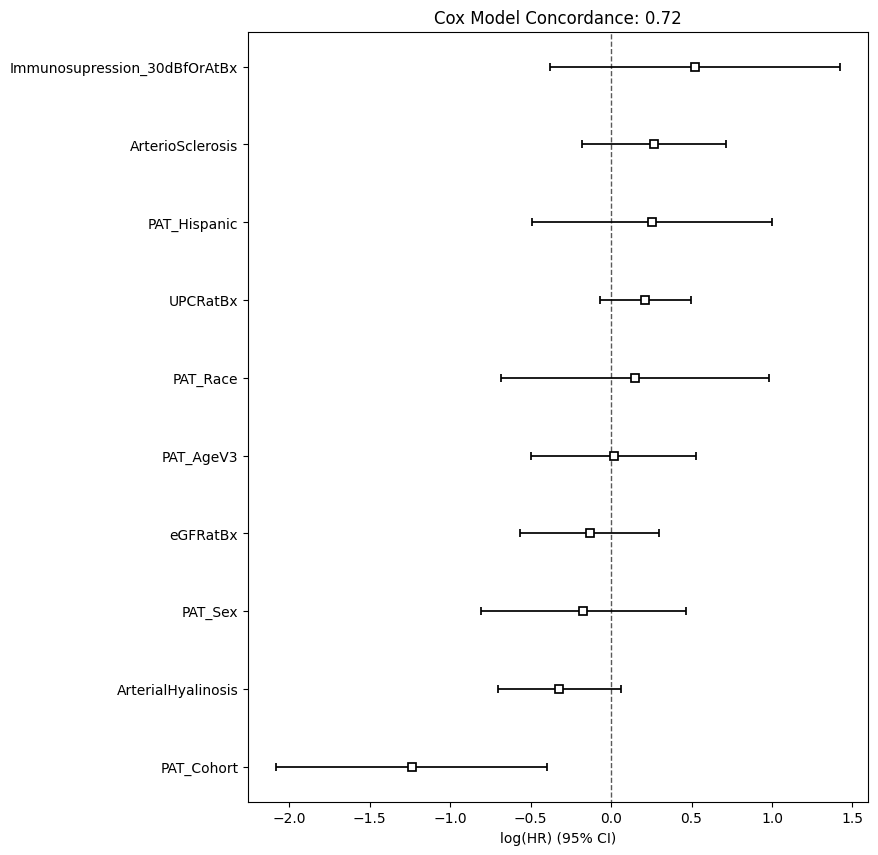

In [11]:
# measurement_features_selected = [x for x in measurement_features if "" in x]
# # score_features_selected = [x for x in score_features if "Arterioles" in x]
# score_features_selected = []

form = "+".join(CLININCAL_FEATURES_W_VISUAL)

# Create a figure and axis object with proper dimensions
fig, ax = plt.subplots(figsize=(8, 10))  # Use subplots instead of figure

# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Plotting the hazard ratios for each feature
cph.plot(ax=ax)

# Setting the title with the concordance index
ax.set_title(f"Cox Model Concordance: {cph.concordance_index_:.2f}")
plt.show()  # Ensure the plot is displayed

In [12]:
# measurement_features_selected = [x for x in measurement_features if "" in x]
# # score_features_selected = [x for x in score_features if "Arterioles" in x]
# score_features_selected = []

form = "+".join(score_features)

# Create a figure and axis object with proper dimensions
# fig, ax = plt.subplots(figsize=(8, 60))  # Use subplots instead of figure

# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Plotting the hazard ratios for each feature
# cph.plot(ax=ax)

# Setting the title with the concordance index
# ax.set_title(f"Cox Model Concordance: {cph.concordance_index_:.2f}")
# plt.show()  # Ensure the plot is displayed

df = cph.summary

# Compute the absolute values of the coefficients and sort them
df['abs_coef'] = df['coef'].abs()
df_sorted = df.sort_values(by='abs_coef', ascending=False)
df_sorted

selected_score_features = df_sorted[df_sorted["abs_coef"] > 0.1].index.values.tolist()
selected_score_features

['Max_Arteriosclerosis_Severity_in_Arterioles',
 'Median_Hyalinosis_Severity_in_Arterioles',
 'NonZeroPct_Arteriosclerosis_Severity_in_Interlobular_Arteries',
 'Median_Arteriosclerosis_Severity_in_Interlobular_Arteries',
 '75th_Hyalinosis_Severity_in_Arterioles',
 'Max_Hyalinosis_Severity_in_Arcuate_Arteries']

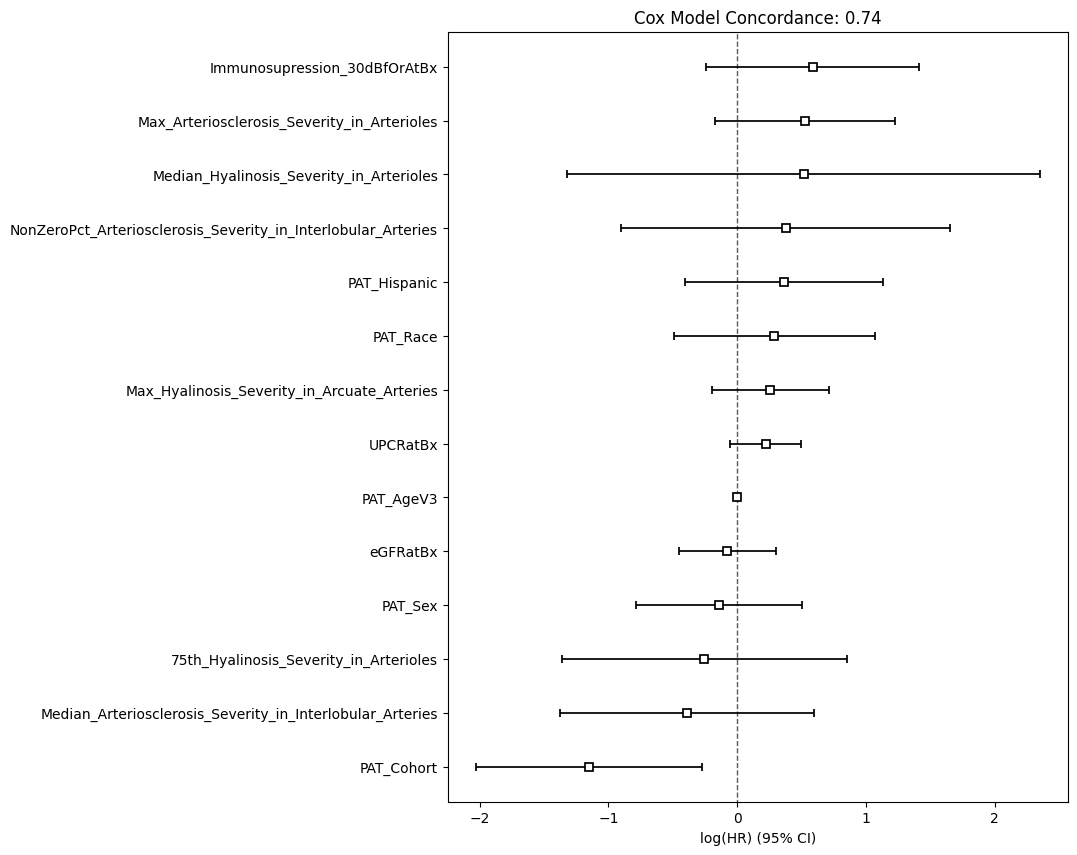

In [13]:
# measurement_features_selected = [x for x in measurement_features if "" in x]
# # score_features_selected = [x for x in score_features if "Arterioles" in x]
# score_features_selected = []

form = "+".join(CLININCAL_FEATURES + selected_score_features)

# Create a figure and axis object with proper dimensions
fig, ax = plt.subplots(figsize=(8, 10))  # Use subplots instead of figure

# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Plotting the hazard ratios for each feature
cph.plot(ax=ax)

# Setting the title with the concordance index
ax.set_title(f"Cox Model Concordance: {cph.concordance_index_:.2f}")
plt.show()  # Ensure the plot is displayed

In [14]:
measurement_features_selected = [x for x in measurement_features if "" in x]
# score_features_selected = [x for x in score_features if "Arterioles" in x]
score_features_selected = []

form = "+".join(measurement_features_selected)

# Create a figure and axis object with proper dimensions
# fig, ax = plt.subplots(figsize=(8, 60))  # Use subplots instead of figure

# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Plotting the hazard ratios for each feature
# cph.plot(ax=ax)

# Setting the title with the concordance index
# ax.set_title(f"Cox Model Concordance: {cph.concordance_index_:.2f}")
# plt.show()  # Ensure the plot is displayed

# Get the summary of the fitted model
df = cph.summary

# Compute the absolute values of the coefficients and sort them
df['abs_coef'] = df['coef'].abs()
df_sorted = df.sort_values(by='abs_coef', ascending=False)
df_sorted

selected_measurement_features = df_sorted[df_sorted["abs_coef"] > 0.1].index.values.tolist()
selected_measurement_features

['Max_Hyalinosis_Area_in_Arterioles',
 '75th_Lumen_Area_in_Arterioles',
 '25th_Media_Area_in_Interlobular_Arteries',
 'Max_Lumen_Area_in_Interlobular_Arteries',
 'Median_Media_Area_in_Arcuate_Arteries']

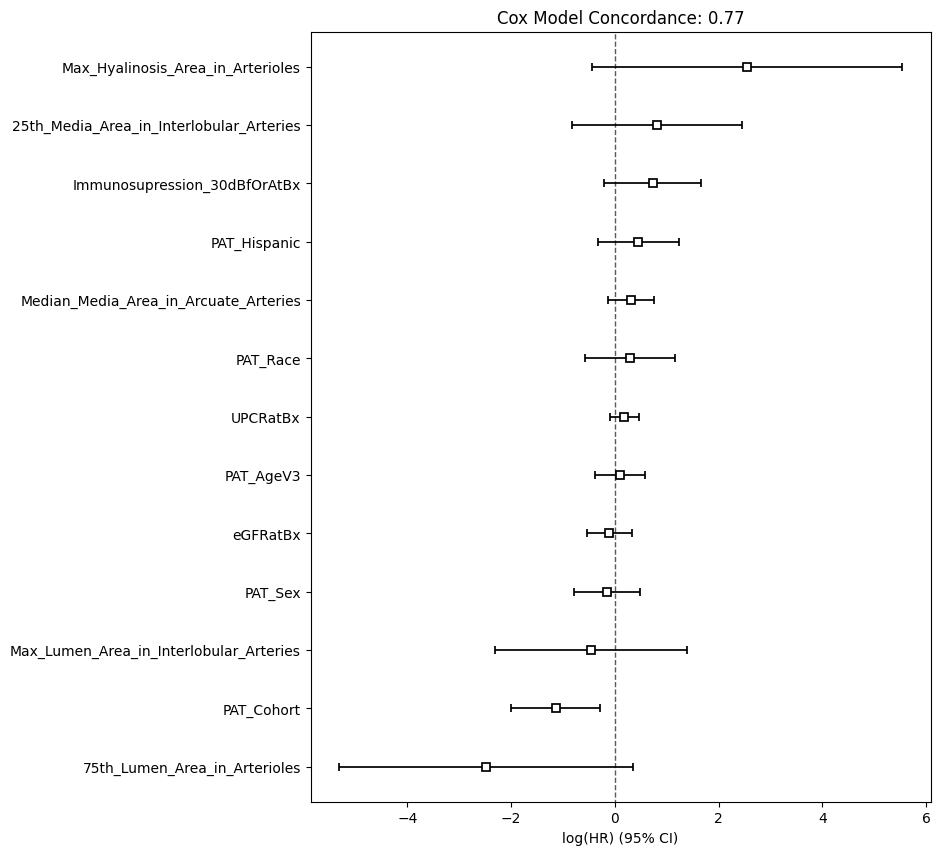

In [15]:
# measurement_features_selected = [x for x in measurement_features if "" in x]
# # score_features_selected = [x for x in score_features if "Arterioles" in x]
# score_features_selected = []

form = "+".join(CLININCAL_FEATURES + selected_measurement_features)

# Create a figure and axis object with proper dimensions
fig, ax = plt.subplots(figsize=(8, 10))  # Use subplots instead of figure

# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Plotting the hazard ratios for each feature
cph.plot(ax=ax)

# Setting the title with the concordance index
ax.set_title(f"Cox Model Concordance: {cph.concordance_index_:.2f}")
plt.show()  # Ensure the plot is displayed

In [ ]:
CLININCAL_FEATURES_WO_VISUAL = ['PAT_Sex',
 'PAT_Hispanic',
 'PAT_Race',
 'PAT_Cohort',
 'PAT_AgeV3',
 'eGFRatBx',
 'UPCRatBx',
 'Immunosupression_30dBfOrAtBx',
#  'ArterioSclerosis',
#  'ArterialHyalinosis'
 ]

CLININCAL_FEATURES = ['PAT_Sex',
 'PAT_Hispanic',
 'PAT_Race',
 'PAT_Cohort',
 'PAT_AgeV3',
 'eGFRatBx',
 'UPCRatBx',
 'Immunosupression_30dBfOrAtBx',
 'ArterioSclerosis',
 'ArterialHyalinosis'
 ]

In [ ]:
pat_df.shape

In [ ]:
measurement_features_selected = [x for x in measurement_features if "" in x]
# score_features_selected = [x for x in score_features if "Arterioles" in x]
score_features_selected = []

form = "+".join(CLININCAL_FEATURES_WO_VISUAL)

# Create a figure and axis object with proper dimensions
fig, ax = plt.subplots(figsize=(4, 6))  # Use subplots instead of figure

# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Plotting the hazard ratios for each feature
cph.plot(ax=ax)

# Setting the title with the concordance index
ax.set_title(f"Cox Model Concordance: {cph.concordance_index_:.2f}")
plt.show()  # Ensure the plot is displayed

In [ ]:
measurement_features_selected = [x for x in measurement_features if "" in x]
# score_features_selected = [x for x in score_features if "Arterioles" in x]
score_features_selected = []

form = "+".join(CLININCAL_FEATURES)

# Create a figure and axis object with proper dimensions
fig, ax = plt.subplots(figsize=(4, 6))  # Use subplots instead of figure

# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Plotting the hazard ratios for each feature
cph.plot(ax=ax)

# Setting the title with the concordance index
ax.set_title(f"Cox Model Concordance: {cph.concordance_index_:.2f}")
plt.show()  # Ensure the plot is displayed

In [ ]:
measurement_features_selected = [x for x in measurement_features if "" in x]
# score_features_selected = [x for x in score_features if "Arterioles" in x]
score_features_selected = []

form = "+".join(CLININCAL_FEATURES + selected_measurement_features)

# Create a figure and axis object with proper dimensions
fig, ax = plt.subplots(figsize=(4, 6))  # Use subplots instead of figure

# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Plotting the hazard ratios for each feature
cph.plot(ax=ax)

# Setting the title with the concordance index
ax.set_title(f"Cox Model Concordance: {cph.concordance_index_:.2f}")
plt.show()  # Ensure the plot is displayed

In [ ]:
measurement_features_selected = [x for x in measurement_features if "" in x]
# score_features_selected = [x for x in score_features if "Arterioles" in x]
score_features_selected = []

form = "+".join(CLININCAL_FEATURES + selected_score_features+selected_measurement_features)

# Create a figure and axis object with proper dimensions
fig, ax = plt.subplots(figsize=(4, 6))  # Use subplots instead of figure

# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Plotting the hazard ratios for each feature
cph.plot(ax=ax)

# Setting the title with the concordance index
ax.set_title(f"Cox Model Concordance: {cph.concordance_index_:.2f}")
plt.show()  # Ensure the plot is displayed

In [ ]:
# Prepare the plotting area
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(40, 15))  # Adjust the grid size based on the number of features
axes = axes.flatten()  # Flatten the axis array for easy iteration

for idx, feature in enumerate([""] + score_features + selected_measurement_features ):
    # Create the formula including ArterioSclerosis as a common comparison feature
    form = "+".join(CLININCAL_FEATURES)
    if feature != "": 
        form += "+" + feature
        title = "Clinical Features + " + feature
    else:
        title = "Clinical Features"
    # Fit the Cox proportional hazards model
    cph = CoxPHFitter(penalizer=0.1, l1_ratio=0.1)
    cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)
    # Plotting the hazard ratios for each feature along with ArterioSclerosis
    ax = axes[idx]
    cph.plot(ax=ax)
    ax.set_title(f"{title}: {cph.concordance_index_:.2f}")  # Title for each subplot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
